`Contributeur: GIANG Phuong-Thu, Cécile (3530406)`

# [LU3IN006] PROJET FINAL - *Problème binaire*
## _Etude de la base de données MNIST_

L'objectif de ce projet est de réaliser des expérimentations à l'aide d'un ou de plusieurs classifieurs vus en cours _(séances de TD-TME 1 à 6)_ et que vous avez implémentés (il n'est pas autorisé d'utiliser un classifieur que vous n'avez pas vous même programmé).

Les **données d'expérimentation** à utiliser sont imposées : ce sont des données issues d'une base très utilisée en datascience, la **base MNIST** (https://fr.wikipedia.org/wiki/Base_de_donn%C3%A9es_MNIST).

Nous avons modifié un peu ces données afin de vous proposer un problème à 2 classes (ou labels) à reconnaître: les deux classes sont celles que l'on a l'habitude de traiter dans nos TD-TME: +1 et -1.

Les expérimentations à réaliser se doublent aussi d'un challenge : il vous faut construire un classifieur à l'aide des exemples de `train.csv` et qui vous permettra d'obtenir le meilleur taux de bonne classification sur le fichier `eval.csv`.

# Sommaire du projet

1. [Pré-traitement des données](#paragraph1)
2. [Vue d'ensemble des données MNIST](#paragraph2)
3. [Classifieur linéaire aléatoire](#paragraph3)
4. [Classifieur du perceptron de Rosenblatt](#paragraph4)
5. [Classifieur KNN](#paragraph5)
6. [Arbre de décisions](#paragraph6)

## Fichiers créés pendant le projet

Les fichiers résultats ont été obtenus en entraînant les classifieurs suivants sur le fichier `train.cvs` et en les évaluant sur le fichier test `eval.cvs`:

- `resultats-1.cvs`: classifications obtenues avec un classifieur **linéaire aléatoire**
- `resultats-2.cvs`: classifications obtenues avec un classifieur **perceptron de Rosenblatt** avec `learning rate = 0.000001`
- `resultats-3.cvs`: classifications obtenues avec un classifieur **perceptron de Rosenblatt** avec `learning rate = 0.001`
- `resultats-4.cvs`: classifications obtenues avec un classifieur **KNN** (*k-plus proches voisins*) pour `k = 10`
- `resultats-5.cvs`: classifications obtenues avec un **arbre de décisions** pour `epsilon = 0.0`

In [1]:
# Importation des librairies standards:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  

# Importation de votre librairie iads:
# La ligne suivante permet de préciser le chemin d'accès à la librairie iads
import sys
sys.path.append('../')   # iads doit être dans le répertoire frère du répertoire courant !

# Importation de la librairie iads
import iads as iads

# importation de Classifiers
from iads import Classifiers as cl

# importation de utils
from iads import utils as ut

# importation de evaluation
from iads import evaluation as ev

## 1. Pré-traitement des données <a name="paragraph1"></a>

À partir des fichiers `train.csv`, `test.csv` et `names.csv` fournis, on veut maintenant créer deux `DataFrame` sur lesquels on expérimentera nos classifieurs:

- `train_df`: qui servira de DataFrame d'apprentissage pour nos modèles
- `test_df`: sur lequel on testera les modèles appris et on calculera le taux de bonne classification

In [2]:
# ----------------- Importation des fichiers `train.csv`, `test.csv`, `names.csv` et `eval.csv`

train_df = pd.read_csv('train.csv', sep=';', header=None)
test_df = pd.read_csv('test.csv', sep=';', header=None)
eval_df = pd.read_csv('eval.csv', sep=';', header=None)
names_df = pd.read_csv('names.csv', sep=';')

# Liste des attributs des datasets ci-dessus (on ne compte ni 'ident', ni 'label')
noms_attributs = names_df.columns[1:-1].tolist()

# Dataframe d'apprentissage: train_df

train_df.columns = names_df.columns
train_desc = np.asarray(train_df[[column for column in train_df.columns[1:-1]]])
train_label = train_df['label'].values

# Dataframe de test: test_df

test_df.columns = names_df.columns
test_desc = np.asarray(test_df[[column for column in test_df.columns[1:-1]]])
test_label = test_df['label'].values

# Dataframe d'évaluation: eval_df

eval_df.columns = names_df.columns
eval_desc = np.asarray(eval_df[[column for column in eval_df.columns[1:-1]]])
eval_ident = eval_df['ident'].values

## 2. Vue d'ensemble de la base de données MNIST <a name="paragraph2"></a>

La base de données **MNIST** (pour _Modified_ ou _Mixed National Institute of Standards and Technology_) est une base de données de de chiffres manuscrits très utilisé en Machine Learning, notamment pour l'entraînement et le test de modèles prédictifs.

La reconnaissance de l'écriture manuscrite est un problème difficile, et un bon test pour les algorithmes d'apprentissage. La base MNIST est devenue un test standard. Elle regroupe 60 000 images d'apprentissage et 10 000 images de test, issues d'une base de données antérieure, appelée simplement NIST. Ce sont des images en noir et blanc, normalisées centrées de 28 pixels de côté.

<img src="mnist_examples.png"  align="middle"> 

Dans les datasets `train_df` et `test_df`, les colonnes correspondent à l'**identifiant** (_unique_) de chaque image, les **pixels** à chaque coordonnée de l'image et enfin le **chiffre** correspondant.

In [3]:
print('\n\t\t\t\t------- Dataset d\'apprentissage -------')
train_df


				------- Dataset d'apprentissage -------


,ident,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28,label
0,10001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1
1,10002,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1
2,10003,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1
3,10004,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1
4,10005,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1
5,10006,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1
6,10007,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1
7,10008,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1
8,10009,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1
9,10010,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1


In [4]:
print('\n\t\t\t\t\t------- Dataset de test -------')
test_df


					------- Dataset de test -------


,ident,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28,label
0,20001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1
1,20002,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1
2,20003,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1
3,20004,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1
4,20005,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1
5,20006,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1
6,20007,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1
7,20008,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1
8,20009,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1
9,20010,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1


Chaque ligne de `train_desc` et de `test_desc` correspondant à un array contenant les pixels pour une image, nous aimerions essayer d'en visualiser quelques unes.

Pour cela implémentons une fonction permettant de plotter une ligne de `train_desc` ou `test_desc`.%

In [5]:
# Fonction qui prend en argument un array 1D et le convertit

def convert2Darray(array_1D):
    
    # Dimension de la matrice 1D
    dim = math.sqrt(len(array_1D))
    
    # Cas où l'on ne peut pas créer de matrice carrée
    if dim != int(dim):
        raise ValueError('On ne peut pas créer de matrice carrée')
    
    dim = int(dim)
    
    # Sinon...
    array_2D = np.zeros((dim,dim))
    
    for i in range(len(array_1D)):
        array_2D[i%dim][i//dim] = array_1D[i]
    
    return array_2D

In [6]:
# Fonction qui prend en argument un array représentant une image, le convertit en matrice 28*28
# puis plotte l'image

def plot_number(array_1D):
    
    # On commence par convertir image en matrice 28*28: attention à ne pas prendre l'identifiant et le label
    array_2D = convert2Darray(array_1D)
    
    # Puis on plotte l'image à partir de la matrice 28*28
    plt.imshow(array_2D, cmap='gray')
    plt.colorbar()
    plt.show()

**Observations:**

Comme nous pouvions nous y attendre, ces images représentent des caractères manuscrits. Chaque caractère est représenté un nombre élevé de fois par des images différentes. Dans `train_desc`:

***Classe -1 de `train_df`: indices de 0 à 499***

- indices 0 à 252 : 3
- 253 à 499: 8

***Classe +1 de `train_df`: indices de 500 à 999***

- 500 à 760: 9
- 761 à 999: 5

------------ Chiffre 3 pour des train_df[0:252] ------------


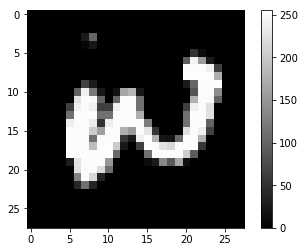

------------ Chiffre 8 pour des train_df[253:499] ------------


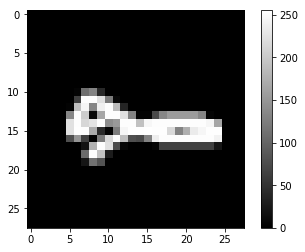

------------ Chiffre 9 pour des train_df[500:760] ------------


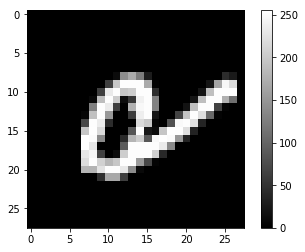

------------ Chiffre 5 pour des train_df[761:999] ------------


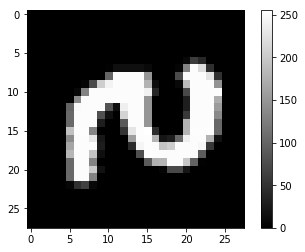

In [7]:
print('------------ Chiffre 3 pour des train_df[0:252] ------------')
plot_number(train_desc[0])

print('------------ Chiffre 8 pour des train_df[253:499] ------------')
plot_number(train_desc[253])

print('------------ Chiffre 9 pour des train_df[500:760] ------------')
plot_number(train_desc[501])

print('------------ Chiffre 5 pour des train_df[761:999] ------------')
plot_number(train_desc[770])

### Pour d'amuser...

On peut essayer pour chacun des chiffres 3, 8, 9 et 5 de faire la moyenne des images et l'afficher.

In [8]:
####### 1ère idée: Trier le dataset d'apprentissage par classe puis faire la moyenne de chaque colonne:
#                  on obtiendra les valeurs moyennes des pixels à chaque point de la matrice
#                  ... On peut alors afficher l'image moyenne de chaque chiffre
####### ----------------------------------------------------------------------------------------------------------------------

## Indice des éléments de classe -1
negative_index = [i for i in range(len(train_label)) if train_label[i]==-1]

## Indice des éléments de classe +1
positive_index = [i for i in range(len(train_label)) if train_label[i]==+1]

In [9]:
"""
Fonction qui, pour un data_set (desc) et une liste d'indices LI renvoie l'array résultant de la moyenne
des valeurs du dataset aux indices de LI
"""

def mean_array(data_desc, LI):
    
    # Array moyen à renvoyer en fin de fonction
    mean = np.zeros(len(data_desc[0]))
    #print('len(mean) = ', len(mean))
    
    for index in LI:
        #print("index = ",index, ': ', len(data_desc[index]))
        mean += data_desc[index]
        
    return mean/len(LI)


------- Image moyenne pour le chiffre 3 de la classe -1 -------


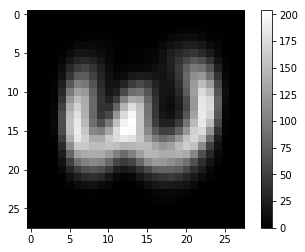


------- Image moyenne pour le chiffre 8 de la classe -1 -------


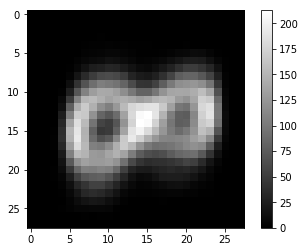

In [10]:
# Affichage des images moyennes pour la classe -1:

# Image moyenne pour le chiffre 3: indice de 0 à 252
print('\n------- Image moyenne pour le chiffre 3 de la classe -1 -------')
plot_number(mean_array(train_desc, negative_index[:253]))

# Image moyenne pour le chiffre 8: indice de 253 à 499

print('\n------- Image moyenne pour le chiffre 8 de la classe -1 -------')
plot_number(mean_array(train_desc, negative_index[253:]))


------- Image moyenne pour le chiffre 9 de la classe +1 -------


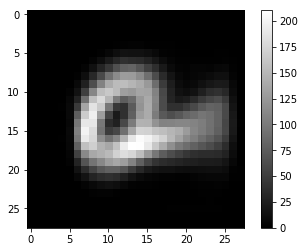


------- Image moyenne pour le chiffre 5 de la classe +1 -------


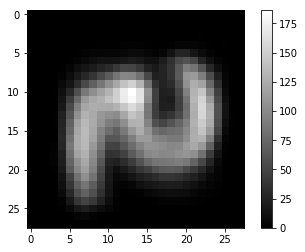

In [11]:
# Affichage des images moyennes pour la classe +1:

# Image moyenne pour le chiffre 9: indice de 500 à 760
print('\n------- Image moyenne pour le chiffre 9 de la classe +1 -------')
plot_number(mean_array(train_desc, positive_index[:261]))

# Image moyenne pour le chiffre 5: indice de 761 à 999

print('\n------- Image moyenne pour le chiffre 5 de la classe +1 -------')
plot_number(mean_array(train_desc, positive_index[261:]))

Dans la suite, on notera `dim` la taille d'une image dans un dataset de MNIST.

In [12]:
dim = len(train_desc[0])
dim

784

## 3. Classifieur Linéaire Aléatoire <a name="paragraph3"></a>

On expérimente d'abord sur le classifieur linéaire aléatoire vu en TME 2. Puisqu'il n'a pas d'étape d'apprentissage et prédit de manière aléatoire uniforme l'une des deux classes -1 ou +1, on ne s'attend pas à un bon taux de classification puisqu'il sera de l'ordre de 0.5 si les classes sont de même effectif dans le dataset evalué.

In [13]:
# ----------------- Expérimentation avec le classifieur linéaire aléatoire

classifieur_aleatoire = cl.ClassifierLineaireRandom(dim)

# On entraîne le classifieur avec train.csv et on affiche:
#        - son accuracy avec des données déjà rencontrées (train.csv)
#        - sa performance, i.e. son accuracy avec de nouvelles données (test.csv)

# Apprentissage sur train.csv
classifieur_aleatoire.train(train_desc, train_label)

print('\n************ Affichage des performances pour un classifieur aléatoire ************')
print('\n\tTaux de bonne classification avec des données déjà rencontrées: ', classifieur_aleatoire.accuracy(train_desc, train_label))
print('\tTaux de bonne classification avec test.csv (performance): ', classifieur_aleatoire.accuracy(test_desc, test_label))


************ Affichage des performances pour un classifieur aléatoire ************

	Taux de bonne classification avec des données déjà rencontrées:  0.5
	Taux de bonne classification avec test.csv (performance):  0.5


> **Taux de bonne classification sur `test.csv` pour `ClassifierLineaireRandom`: 0.5**

Comme on ne peut pas utiliser la fonction `ut.plot2DSet` pour tracer **la frontière entre les classes -1 et +1**, nous allons plutôt comparer graphiquement le graphe des labels attendus (labels dans `test_labels`) par image de `test.csv`au graphe des labels prédits en utilisant le classifieur linéaire aléatoire déjà entraîné.

In [14]:
import umap
import seaborn as sns

""" Fonction qui permet de plotter un dataset dont chaque exemple est un vecteur à variables multiples (> 2 possible)
    Elle utilise le module umap
    Sur Anaconda: - conda config --add channels conda-forge
                  - conda install -c conda-forge umap-learn
"""
def plotMultivariateSet(desc_set, label_set, classifieur):
    
    print('\n***************** LABELS ATTENDUS vs LABELS PREDITS *****************')
    print('\n\n\tClasse -1 en marron \n\tClasse +1 en bleu')
    
    # Affichage des classes attendues
    reducer = umap.UMAP()
    embedding = reducer.fit_transform(desc_set)
    
    plt.figure()
    plt.scatter(embedding[:, 0], embedding[:, 1], c=label_set, cmap='Paired', s=5)
    plt.gca().set_aspect('equal', 'datalim')
    plt.title('Projection en 2D UMAP des images des classes voulues', fontsize=24);
    
    #Affichade des classes prédites
    predicted_label = np.zeros(len(desc_set), dtype=int)
    for i in range(len(desc_set)):
        predicted_label[i] = (classifieur.predict(desc_set[i]))

    reducer = umap.UMAP()
    embedding = reducer.fit_transform(desc_set)
    
    plt.figure()
    plt.scatter(embedding[:, 0], embedding[:, 1], c=predicted_label, cmap='Paired', s=5)
    plt.gca().set_aspect('equal', 'datalim')
    plt.title('Projection en 2D UMAP des images des classes prédites', fontsize=24);


***************** LABELS ATTENDUS vs LABELS PREDITS *****************


	Classe -1 en marron 
	Classe +1 en bleu


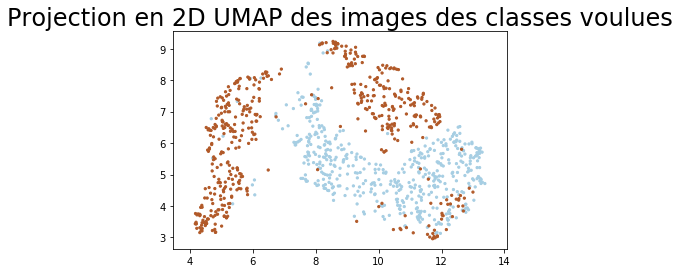

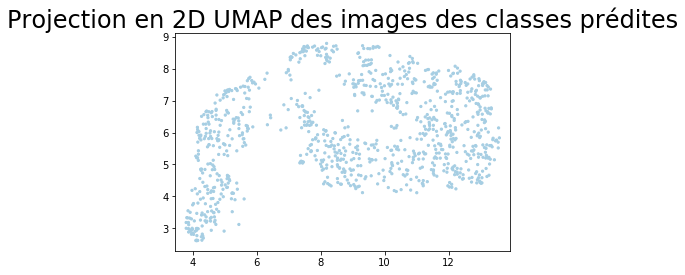

In [15]:
# Labels voulus vs labels obtenus avec le CLASSIFIEUR ALEATOIRE
plotMultivariateSet(test_desc, test_label, classifieur_aleatoire)

On crée maintenant le fichier `resultat-1.csv` qui contiendra les classes prédites par `classifieur_aleatoire` pour chaque exemple de `eval.csv`.

In [15]:
""" Crée un fichier `resultat.csv` (`resultat-1.csv`, `resultat-2.csv`, etc...)
    qui contient 2 colonnes séparées par un point-virgule (;) :
            -> la première colonne donne l'identifiant d'un exemple de eval.csv
            -> la deuxième colonne donne le label (+1 ou +1) trouvé par votre classifieur pour l'exemple correspondant
"""

def creer_resultats_csv(num_fichier, classifieur):
    
    """ On suppose le classifieur déjà entraîné.
    """
    # Création du fichier
    fichier = open('resultats-' + str(num_fichier) + '.csv', 'w')
    
    # Ecriture des labels prédits par exemple de eval.csv
    for i in range(len(eval_df)):
        fichier.write(str(eval_ident[i]) + ';' + str(classifieur.predict(eval_desc[i])) + '\n')
        
    fichier.close()


**Création de `resultats-1.cvs`**:

In [18]:
# ------------ Création de `resultats-1.csv`

creer_resultats_csv(1, classifieur_aleatoire)

## 4. Classifieur du perceptron de Ronsenblatt <a name="paragraph4"></a>

Nous expérimentons maintenant sur le classifieur dit _perceptron de Rosenblatt_. Nous ferons à chaque fois évoluer le paramètre `learning_rate`, qui est la vitesse d'apprentissage du classifieur.

In [16]:
# ----------------- Expérimentation avec le classifieur du perceptron de Rosenblatt

for learning_rate in [0.01,0.3,0.5,0.7]:
    
    classifieur_perceptron = cl.ClassifierPerceptron(dim, learning_rate)
    classifieur_perceptron.train(train_desc, train_label)
    
    print('\n\n\n***************** Affichage des performances pour un classifieur perceptron *****************')
    print('\nPour learning_rate = ', learning_rate)
    print('\n\tTaux de bonne classification avec des données déjà rencontrées: ', classifieur_perceptron.accuracy(train_desc, train_label))
    print('\tTaux de bonne classification avec test.csv (performance): ', classifieur_perceptron.accuracy(test_desc, test_label))




***************** Affichage des performances pour un classifieur perceptron *****************

Pour learning_rate =  0.01

	Taux de bonne classification avec des données déjà rencontrées:  0.883
	Taux de bonne classification avec test.csv (performance):  0.854



***************** Affichage des performances pour un classifieur perceptron *****************

Pour learning_rate =  0.3

	Taux de bonne classification avec des données déjà rencontrées:  0.892
	Taux de bonne classification avec test.csv (performance):  0.88



***************** Affichage des performances pour un classifieur perceptron *****************

Pour learning_rate =  0.5

	Taux de bonne classification avec des données déjà rencontrées:  0.893
	Taux de bonne classification avec test.csv (performance):  0.849



***************** Affichage des performances pour un classifieur perceptron *****************

Pour learning_rate =  0.7

	Taux de bonne classification avec des données déjà rencontrées:  0.833
	Taux de bonne

> **Taux de bonne classification sur `test.csv` pour `ClassifierPerceptron` avec `learning_rate = 0.01`: 0.854**

> **Taux de bonne classification sur `test.csv` pour `ClassifierPerceptron` avec `learning_rate = 0.3`: 0.88**

> **Taux de bonne classification sur `test.csv` pour `ClassifierPerceptron` avec `learning_rate = 0.5`: 0.849**

> **Taux de bonne classification sur `test.csv` pour `ClassifierPerceptron` avec `learning_rate = 0.7`: 0.786**

### Evolution de l'accuracy de `ClassifierPerceptron` en fonction de `learning_rate`

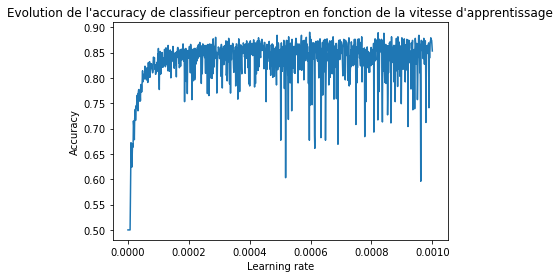

In [41]:
## EVOLUTION DE L'ACCURACY SELON LA VALEUR DE LEARNING_RATE
dim = len(train_desc[0])
learning_rate = np.arange(0,0.001,0.000001)
accuracy = []

for i in learning_rate:
    cp = cl.ClassifierPerceptron(dim, i)
    cp.train(train_desc, train_label)
    accuracy.append(cp.accuracy(test_desc, test_label))

plt.plot(learning_rate, accuracy)
plt.xlabel('Learning rate')
plt.ylabel('Accuracy')
plt.title('Evolution de l\'accuracy de classifieur perceptron en fonction de la vitesse d\'apprentissage')
plt.show()

**Observations:**

Nous observons que pour un `learning_rate` trop bas (inférieur à 0.0002), le classifieur sous-apprend et affiche une performance similaire au classifieur aléatoire (car les coefficients synaptiques définis par son attribut `omega`, tiré aléatoirement, ne subit alors presque aucun changement avec un `learning_rate` aussi bas).

Pour un `learning_rate` assez grand (supérieur à 0.0002), la performance se stabilise et est en général comprise entre 0.8 et 0.9.

Comparons maintenant les labels attendus (ceux décrits dans `test_label`) avec les labels obtenus en prédisant sur `test_desc` avec notre classifieur perceptron.

### Comparaison classes attendues vs classes prédites sur `test.csv`

**Avec `learning_rate = 0.001`**: on a en général une bonne prédiction sur les classes


***************** LABELS ATTENDUS vs LABELS PREDITS *****************


	Classe -1 en marron 
	Classe +1 en bleu


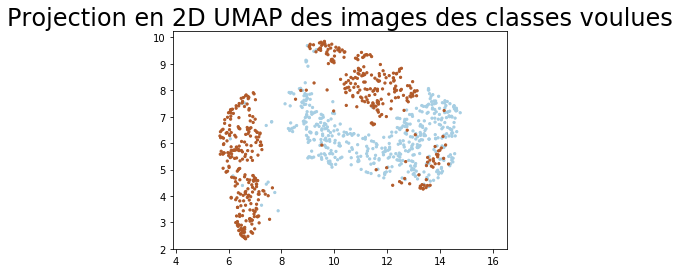

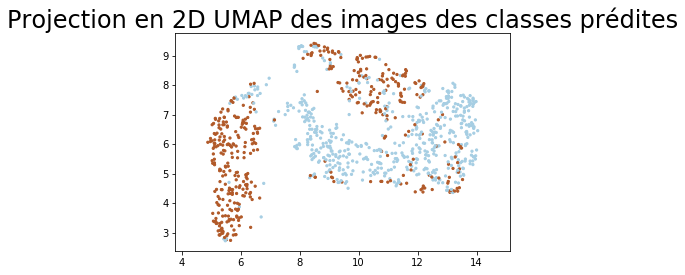

In [27]:
# Pour un learning rate de 0.001

classifieur_perceptron = cl.ClassifierPerceptron(dim, 0.001)
classifieur_perceptron.train(train_desc, train_label)

# Labels voulus vs labels obtenus avec le CLASSIFIEUR PERCEPTRON DE ROSENBLATT
plotMultivariateSet(test_desc, test_label, classifieur_perceptron)

**Avec `learning_rate = 0.000001`**: vitesse d'apprentissage trop basse, revient à une prédiction aléatoire


***************** LABELS ATTENDUS vs LABELS PREDITS *****************


	Classe -1 en marron 
	Classe +1 en bleu


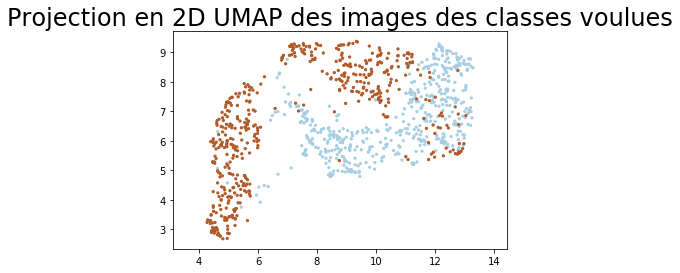

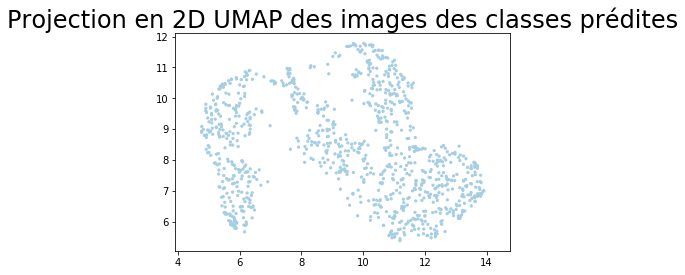

In [28]:
# Pour un learning rate de 0.000001

classifieur_perceptron = cl.ClassifierPerceptron(dim, 0.000001)
classifieur_perceptron.train(train_desc, train_label)

# Labels voulus vs labels obtenus avec le CLASSIFIEUR PERCEPTRON DE ROSENBLATT
plotMultivariateSet(test_desc, test_label, classifieur_perceptron)

On crée maintenant les fichiers `resultat-2.csv` et `resultat-3.csv` qui contiendront respectivement:

- `resultat-2.csv`: les classes prédites par `classifieur_perceptron` pour chaque exemple de `eval.csv` avec `learning_rate = 0.000001`
- `resultat-3.csv`: les classes prédites par `classifieur_perceptron` pour chaque exemple de `eval.csv` avec `learning_rate = 0.001`

In [21]:
# ------------ Création de `resultats-2.csv` et de `resultats-3.csv`

# classifieur_perceptron_1 pour un learning rate de 0.000001
classifieur_perceptron_1 = cl.ClassifierPerceptron(dim, 0.000001)
classifieur_perceptron_1.train(train_desc, train_label)

# classifieur_perceptron_2 pour un learning rate de 0.001 (à garder absolument)
classifieur_perceptron_2 = cl.ClassifierPerceptron(dim, 0.001)
classifieur_perceptron_2.train(train_desc, train_label)

creer_resultats_csv(2, classifieur_perceptron_1)
creer_resultats_csv(3, classifieur_perceptron_2)

## 5. Classifieur KNN ($k$-plus proches voisins) <a name="paragraph5"></a>

Nous expérimentons maintenant sur le classifieur dit **KNN** (_k nearest neighbors_ ou _k-plus proches voisins_ en français). Nous ferons à chaque fois évoluer le paramètre `k`, qui est le nombre de voisins pris en compte dans la prédiction de la classe, pour un exemple du dataset étudié.

In [53]:
# ----------------- Expérimentation avec le classifieur KNN

for k in [1, 5, 10, 50, 100, 200]:
    
    classifieur_knn = cl.ClassifierKNN(dim, k)
    classifieur_knn.train(train_desc, train_label)
    
    print('\n\n\n***************** Affichage des performances pour un classifieur KNN *****************')
    print('\nPour k = ', k)
    print('\n\tTaux de bonne classification avec des données déjà rencontrées: ', classifieur_knn.accuracy(train_desc, train_label))
    print('\tTaux de bonne classification avec test.csv (performance): ', classifieur_knn.accuracy(test_desc, test_label))




***************** Affichage des performances pour un classifieur KNN *****************

Pour k =  1

	Taux de bonne classification avec des données déjà rencontrées:  1.0
	Taux de bonne classification avec test.csv (performance):  0.935



***************** Affichage des performances pour un classifieur KNN *****************

Pour k =  5

	Taux de bonne classification avec des données déjà rencontrées:  0.965
	Taux de bonne classification avec test.csv (performance):  0.946



***************** Affichage des performances pour un classifieur KNN *****************

Pour k =  10

	Taux de bonne classification avec des données déjà rencontrées:  0.957
	Taux de bonne classification avec test.csv (performance):  0.945



***************** Affichage des performances pour un classifieur KNN *****************

Pour k =  50

	Taux de bonne classification avec des données déjà rencontrées:  0.92
	Taux de bonne classification avec test.csv (performance):  0.911



***************** Affichage de

> **Taux de bonne classification sur `test.csv` pour `ClassifierKNN` avec `k = 1`: 0.935**

> **Taux de bonne classification sur `test.csv` pour `ClassifierKNN` avec `k = 5`: 0.946**

> **Taux de bonne classification sur `test.csv` pour `ClassifierKNN` avec `k = 10`: 0.945**

> **Taux de bonne classification sur `test.csv` pour `ClassifierKNN` avec `k = 50`: 0.911**

> **Taux de bonne classification sur `test.csv` pour `ClassifierKNN` avec `k = 100`: 0.886**

> **Taux de bonne classification sur `test.csv` pour `ClassifierKNN` avec `k = 200`: 0.851**

### Evolution de l'accuracy de `ClassifierKNN` en fonction de `k`

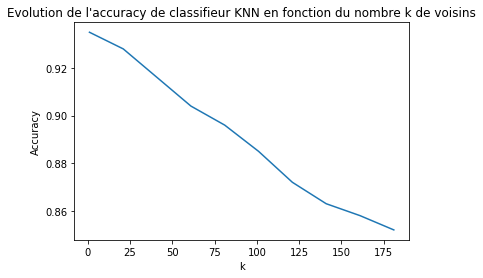

In [58]:
## EVOLUTION DE L'ACCURACY SELON LA VALEUR DE K
dim = len(train_desc[0])
k_list = [k for k in range(1,201,20)]
accuracy = []

for k in k_list:
    ck = cl.ClassifierKNN(dim, k)
    ck.train(train_desc, train_label)
    accuracy.append(ck.accuracy(test_desc, test_label))

plt.plot(k_list, accuracy)
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Evolution de l\'accuracy de classifieur KNN en fonction du nombre k de voisins')
plt.show()

Comme l'on pouvait s'y attendre, le mieux est de prendre un `k` non-nul, ni trop petit (pour éviter de mal classer si l'on prédit sur un exemple se trouvant à la frontière des 2 classes), ni trop grand (auquel cas cela reviendrait juste à prendre la classe majoritaire).

### Comparaison classes attendues vs classes prédites sur `test.csv`

**Avec `k = 10`**: on a en général une bonne prédiction sur les classes


***************** LABELS ATTENDUS vs LABELS PREDITS *****************


	Classe -1 en marron 
	Classe +1 en bleu


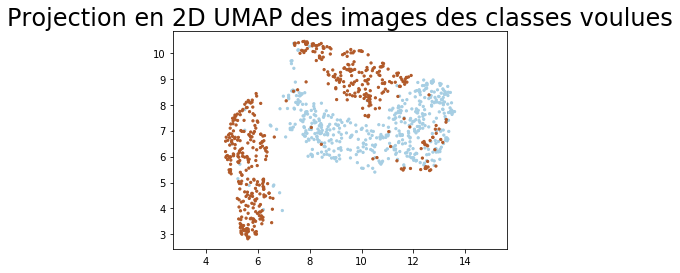

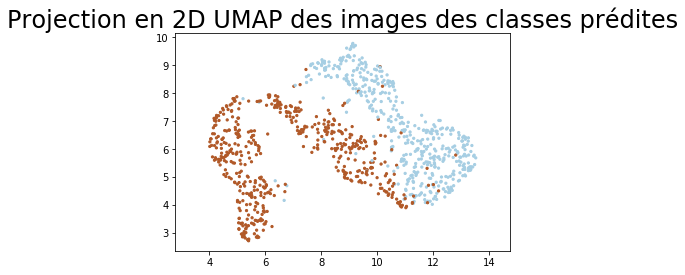

In [31]:
# Pour un k de 10

classifieur_knn = cl.ClassifierKNN(dim, 10)
classifieur_knn.train(train_desc, train_label)

# Labels voulus vs labels obtenus avec le CLASSIFIEUR KNN
plotMultivariateSet(test_desc, test_label, classifieur_knn)

**Avec `k = 200`**: taux de bonne classification plus faible car moyennée sur trop de voisins


***************** LABELS ATTENDUS vs LABELS PREDITS *****************


	Classe -1 en marron 
	Classe +1 en bleu


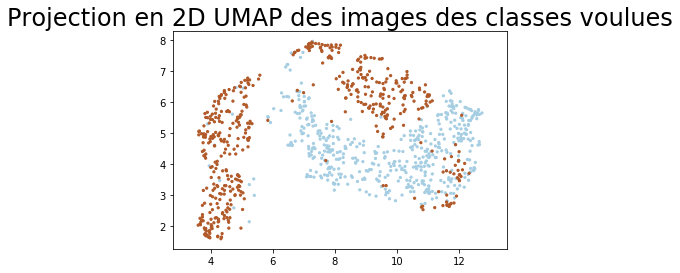

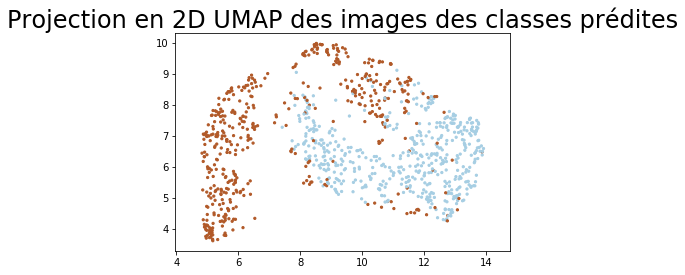

In [32]:
# Pour un k de 200

classifieur_knn = cl.ClassifierKNN(dim, 200)
classifieur_knn.train(train_desc, train_label)

# Labels voulus vs labels obtenus avec le CLASSIFIEUR KNN
plotMultivariateSet(test_desc, test_label, classifieur_knn)

On crée maintenant le fichier `resultat-4.csv` qui contiendra les classes prédites par `classifieur_knn` pour chaque exemple de `eval.csv` avec `k = 10`.

In [35]:
# ------------ Création de `resultats-4.csv`

# classifieur_knn pour k = 10
classifieur_knn = cl.ClassifierKNN(dim, 10)
classifieur_knn.train(train_desc, train_label)

creer_resultats_csv(4, classifieur_knn)

## 6. Arbre de décisions <a name="paragraph6"></a>

Nous expérimentons enfin sur un **_arbre de décision_**. Nous ferons à chaque fois évoluer le paramètre `epsilon`, qui est le seuil d'entropie pour le critère d'arrêt de la construction de l'arbre.

<font color="RED" size = +1>**Note importante sur le codage de l\'arbre:**</font>

Nous rencontrons un problème lorsque nous essayons de classifier un exemple `test_desc[i]` depuis un certain noeud (chaque noeud correspondant à un attribut, et ses fils aux valeurs prises par cet attribut) alors que le classifieur n'avait pas rencontré la valeur d'attribut `test_desc[i][attribut]` pendant la phase d'apprentissage.

Dans le TME 3, la fonction de classification se contentait alors de retourner 0, ce qui faussait beaucoup la classification et au final, en testant un tel classifieur sur `test_desc`, j'obtiens un taux de bonne classification de `0.594`.

J'ai modifié le traitement de ce cas particulier ainsi: si `test_desc[i][attribut]` ne fait pas partie des fils du noeud courant (i.e. que l'arbre ne sait pas comment poursuivre son chemin dans l'arbre), alors la classe présite sera la classe majoritaire depuis le noeud courant.

Nous testons cette méthode et trouvons le taux de bonne classification ci-dessous:

In [22]:
# ----------------- Expérimentation avec un arbre de décision

for epsilon in [0, 0.001, 0.5, 1]:
    
    arbre_de_decision = cl.ClassifierArbreDecision(len(noms_attributs), epsilon, noms_attributs)
    arbre_de_decision.train(train_desc, train_label)
    
    print('\n\n\n***************** Affichage des performances pour un Arbre de Décisions *****************')
    print('\nPour epsilon = ', epsilon)
    print('\n\tTaux de bonne classification avec des données déjà rencontrées: ', arbre_de_decision.accuracy(train_desc, train_label))
    print('\tTaux de bonne classification avec test.csv (performance): ', arbre_de_decision.accuracy(test_desc, test_label))




***************** Affichage des performances pour un Arbre de Décisions *****************

Pour epsilon =  0

	Taux de bonne classification avec des données déjà rencontrées:  1.0
	Taux de bonne classification avec test.csv (performance):  0.687



***************** Affichage des performances pour un Arbre de Décisions *****************

Pour epsilon =  0.001

	Taux de bonne classification avec des données déjà rencontrées:  1.0
	Taux de bonne classification avec test.csv (performance):  0.687



***************** Affichage des performances pour un Arbre de Décisions *****************

Pour epsilon =  0.5

	Taux de bonne classification avec des données déjà rencontrées:  0.991
	Taux de bonne classification avec test.csv (performance):  0.69



***************** Affichage des performances pour un Arbre de Décisions *****************

Pour epsilon =  1

	Taux de bonne classification avec des données déjà rencontrées:  0.5
	Taux de bonne classification avec test.csv (performance):  0.5

> **Taux de bonne classification sur `test.csv` pour `ClassifierArbreDecision` avec `epsilon = 0.0`: 0.687**

> **Taux de bonne classification sur `test.csv` pour `ClassifierArbreDecision` avec `epsilon = 0.001`: 0.687**

> **Taux de bonne classification sur `test.csv` pour `ClassifierArbreDecision` avec `epsilon = 0.5`: 0.69**

> **Taux de bonne classification sur `test.csv` pour `ClassifierArbreDecision` avec `epsilon = 1`: 0.5**


### Comparaison classes attendues vs classes prédites sur `test.csv`

**Avec `epsilon = 0.0`**: on a en général un taux de bonne classification de `accuracy = 0.687`


***************** LABELS ATTENDUS vs LABELS PREDITS *****************


	Classe -1 en marron 
	Classe +1 en bleu


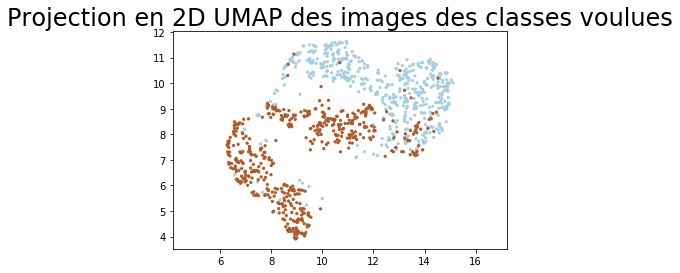

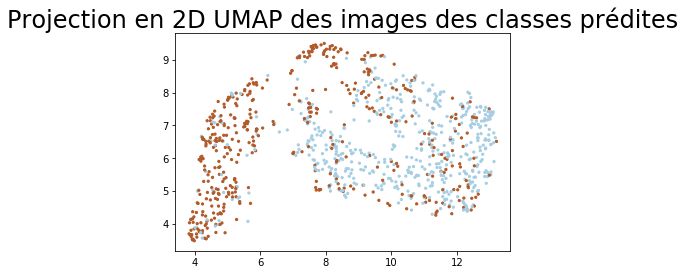

In [20]:
# Pour un epsilon de 0.0

arbre_de_decision = cl.ClassifierArbreDecision(len(noms_attributs), 0.0, noms_attributs)
arbre_de_decision.train(train_desc, train_label)

# Labels voulus vs labels obtenus avec le CLASSIFIEUR KNN
plotMultivariateSet(test_desc, test_label, arbre_de_decision)

On crée maintenant le fichier `resultat-5.csv` qui contiendra les classes prédites par `arbre_de_decision` pour chaque exemple de `eval.csv` avec `epsilon = 0.0`.

In [21]:
# ------------ Création de `resultats-5.csv`

# arbre_de_decision pour epsilon = 0.0
arbre_de_decision = cl.ClassifierArbreDecision(len(noms_attributs), 0.0, noms_attributs)
arbre_de_decision.train(train_desc, train_label)

creer_resultats_csv(5, arbre_de_decision)